# Analysis of the rankings obtained in the EmailEnron hypergraph

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import scienceplots

plt.style.use(['science', 'no-latex'])

from collections import defaultdict

In [5]:
df = pandas.read_csv("../../Output/email-enron_dataframe.csv")

In [6]:
df.drop("AltUnif-2", axis=1, inplace=True)

We have to sort the columns before showing the KT plots. This is a bit more cumbersome than it should due to the alphabetical sorting.

In [7]:
def sortcolumns(df):

    labeldict = {"U":[], "H":[], "A":[]}
    for label in df.columns:
        if "UPHEC" in label:
            labeldict["U"].append(label)
        elif "Alt" in label:
            labeldict["A"].append(label)
        elif "CEC" not in label:
            labeldict["H"].append(label)
    
    # Sort UPHEC, AltUnif
    for key in ["U","A"]:
        labeldict[key] = sorted(labeldict[key])
    
    # Sort the remaining one according to its number
    Hmindex = [int(label.split("-")[1].split("u")[0]) for label in labeldict["H"]]
    labeldict["H"] = list(np.array(labeldict["H"])[np.argsort(Hmindex)])
     
    return df.reindex(["CEC"]+ labeldict["U"]+ labeldict["H"]+ labeldict["A"], axis=1)

In [8]:
df = sortcolumns(df)

In [9]:
#df[labeldict["U"] + labeldict["A"]]

In [10]:
df.sum() # consistency check

CEC           1.0
UPHEC-2       1.0
UPHEC-3       1.0
UPHEC-4       1.0
UPHEC-5       1.0
HEC-2unif     1.0
HEC-3unif     1.0
HEC-4unif     1.0
HEC-5unif     1.0
HEC-6unif     1.0
HEC-7unif     1.0
HEC-8unif     1.0
HEC-9unif     1.0
HEC-10unif    1.0
HEC-11unif    1.0
HEC-12unif    1.0
HEC-13unif    1.0
HEC-15unif    1.0
HEC-16unif    1.0
HEC-18unif    1.0
HEC-36unif    1.0
HEC-37unif    1.0
AltUnif-3     1.0
AltUnif-4     1.0
AltUnif-5     1.0
dtype: float64

In [11]:
#series2 = df["HEC-2unif"]
#series2[series2 > 0].count()

In [12]:
#series5 = df["AltUnif-5"]
#series5obtained

## Complete ranking - Kendall's tau

In [13]:
KT = np.zeros((len(df.columns),len(df.columns)))
for i, row in enumerate(df):
    for j, col in enumerate(df):
        KT[i,j] = scipy.stats.kendalltau(df[row],df[col]).statistic

In [14]:
np.min(KT)

0.06156171203459836

In [15]:
def findInt(col):
    index = col.find("-")
    for n in [3,2,1]:
        try:
            M = int(col[index+1:index+n])
            return str(M)
        except:
            continue
labels = [str(col)[0]+findInt(col) for col in list(df.columns)[1:]]

type_dict = defaultdict(int)
for cent in labels:
    type_dict[cent[0]] += 1
    
separators = [type_dict["U"], type_dict["H"]+type_dict["U"]]

In [16]:
print(type_dict)

defaultdict(<class 'int'>, {'U': 4, 'H': 17, 'A': 3})


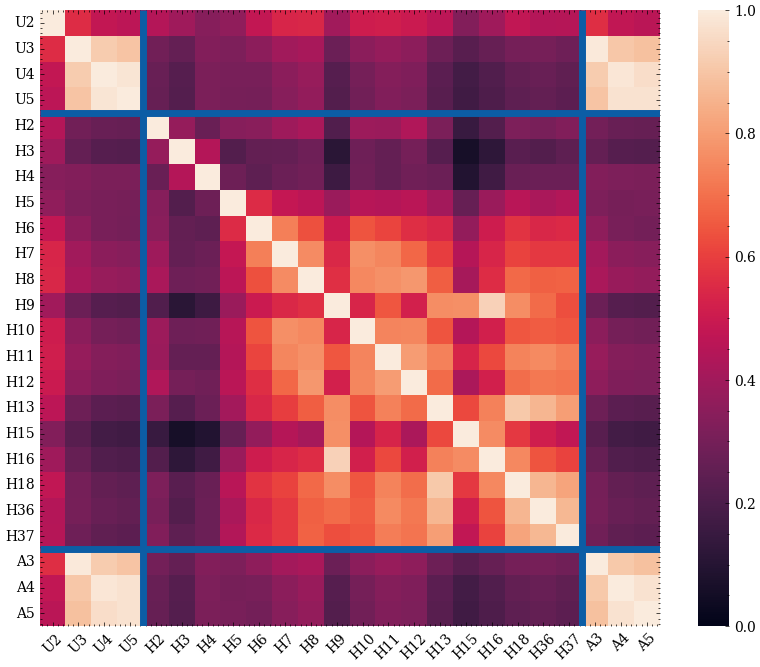

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax = sns.heatmap(KT[1:,1:], annot=False, vmin=0, vmax=1)

ax.hlines(separators, *ax.get_xlim(), linewidth=5)
ax.vlines(separators, *ax.get_ylim(), linewidth=5)

ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45)

#plt.savefig("Figures/KT_heatmap.svg")

plt.show()

In [18]:
def drop_H(KT, type_dict, labels):
    """
    Keep only the parts corresponding to the UPHEC and the Blowup
    """

    lenu = type_dict["U"]
    lenh = type_dict["H"]
    lenuh = lenu + lenh
    lena = type_dict["A"]
    
    KT_reduced = np.zeros([lenu+lena,lenu+lena])

    # UU
    KT_reduced[0:lenu, 0:lenu] = KT[1:lenu+1,1:lenu+1]
    # UA, AU
    KT_reduced[0:lenu, lenu:lenu+lena] = KT[1:lenu+1,1+lenuh:1+lenuh+lena]
    KT_reduced[lenu:lenu+lena, 0:lenu] = KT[1+lenuh:1+lenuh+lena,1:lenu+1]
    # AA
    KT_reduced[lenu:lenu+lena, lenu:lenu+lena] = KT[1+lenuh:1+lenuh+lena,1+lenuh:1+lenuh+lena]

    labels_reduced = ["U2/B2"] + labels[1:lenu] + [lab.replace("A","B") for lab in labels[lenuh:lenuh+lena]]
    
    return KT_reduced, labels_reduced

KT_reduced, labels_reduced = drop_H(KT, type_dict, labels)

In [19]:
labels_reduced

['U2/B2', 'U3', 'U4', 'U5', 'B3', 'B4', 'B5']

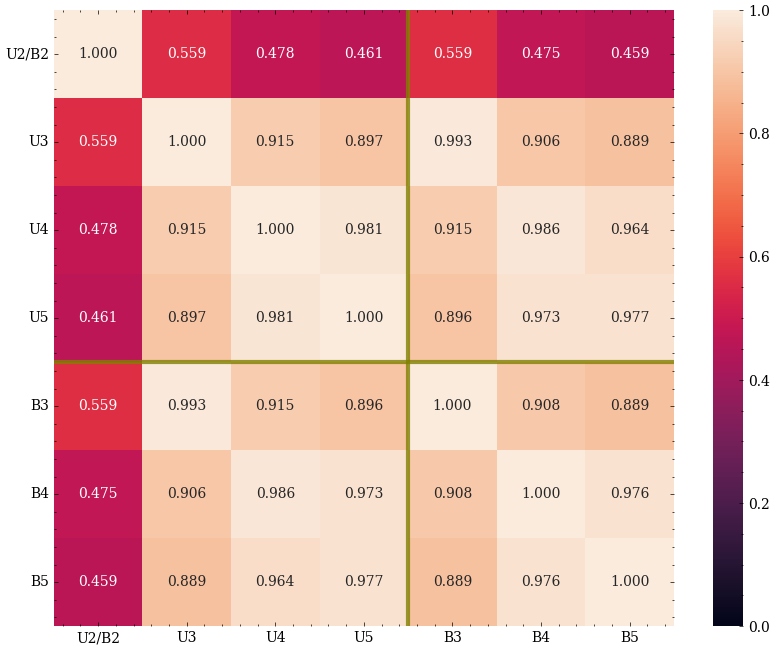

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax = sns.heatmap(KT_reduced, annot=True, fmt=".3f", vmin=0, vmax=1)

ax.hlines(type_dict["U"], *ax.get_xlim(), linewidth=3, color='olive',alpha=0.8)
ax.vlines(type_dict["U"], *ax.get_ylim(), linewidth=3, color='olive',alpha=0.8)

ax.set_yticklabels(labels_reduced, rotation=0)
ax.set_xticklabels(labels_reduced, rotation=0)

plt.savefig("../../Figures/KT-DIS_reduc_heatmap.svg")

plt.show()

## Top-K ranking


In [15]:
## Top K nodes based on a centrality dictionary ##
def topK(cent, K=None, return_list=False):
    """
    Given a dictionary node-centrality score, return the top K ranking
    """

    if not K:
        K = len(cent)
    
    C = sorted(cent, key=cent.get, reverse=True)[:K]
    ranking = {key: cent[key] for key in C}
    
    if return_list:
        return C

    return ranking

In [16]:
dictlist = df.to_dict()

In [17]:
for key1, value1 in dictlist.items():
    print(key1, topK(value1,K=10).keys())

CEC dict_keys([5, 1, 14, 18, 6, 22, 43, 23, 20, 11])
UPHEC-2 dict_keys([5, 1, 14, 43, 18, 6, 22, 40, 33, 23])
UPHEC-3 dict_keys([43, 14, 33, 5, 27, 40, 13, 70, 37, 45])
UPHEC-4 dict_keys([43, 33, 14, 27, 40, 13, 70, 37, 45, 52])
UPHEC-5 dict_keys([43, 33, 14, 27, 13, 70, 37, 45, 40, 52])
HEC-2unif dict_keys([40, 14, 18, 36, 38, 27, 39, 21, 1, 33])
HEC-3unif dict_keys([18, 14, 89, 100, 24, 39, 31, 40, 46, 70])
HEC-4unif dict_keys([94, 90, 82, 88, 87, 27, 93, 85, 86, 91])
HEC-5unif dict_keys([17, 15, 18, 20, 19, 16, 0, 67, 1, 12])
HEC-6unif dict_keys([21, 20, 18, 23, 52, 0, 19, 22, 65, 25])
HEC-7unif dict_keys([11, 6, 5, 10, 9, 4, 8, 7, 13, 25])
HEC-8unif dict_keys([13, 27, 28, 15, 19, 5, 1, 16, 18, 17])
HEC-9unif dict_keys([4, 3, 5, 8, 9, 11, 13, 20, 6, 7])
HEC-10unif dict_keys([1, 24, 31, 2, 5, 20, 3, 52, 30, 15])
HEC-11unif dict_keys([4, 3, 5, 6, 8, 10, 11, 21, 0, 13])
HEC-12unif dict_keys([25, 30, 42, 1, 2, 14, 29, 32, 27, 3])
HEC-13unif dict_keys([3, 4, 13, 21, 24, 26, 0, 1, 2, 5])


In [18]:
KTtopK = defaultdict(list)

for key1, value1 in dictlist.items():
    
    print("Comparing", key1, "against the rest.")
    
    for key2, value2 in dictlist.items():
        
        if key1 == key2:
            continue
        
        for k in range(1, len(df)):
                        
            topk1 = topK(value1, K=k)
            centrals2 = [value2[node] for node in topk1.keys()]
            
            KTtopK[key1 + " -> " + key2].append( scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic )

Comparing CEC against the rest.
Comparing UPHEC-2 against the rest.
Comparing UPHEC-3 against the rest.
Comparing UPHEC-4 against the rest.
Comparing UPHEC-5 against the rest.
Comparing HEC-2unif against the rest.
Comparing HEC-3unif against the rest.
Comparing HEC-4unif against the rest.
Comparing HEC-5unif against the rest.
Comparing HEC-6unif against the rest.
Comparing HEC-7unif against the rest.
Comparing HEC-8unif against the rest.
Comparing HEC-9unif against the rest.
Comparing HEC-10unif against the rest.
Comparing HEC-11unif against the rest.
Comparing HEC-12unif against the rest.
Comparing HEC-13unif against the rest.
Comparing HEC-15unif against the rest.
Comparing HEC-16unif against the rest.
Comparing HEC-18unif against the rest.
Comparing HEC-36unif against the rest.
Comparing HEC-37unif against the rest.
Comparing AltUnif-3 against the rest.
Comparing AltUnif-4 against the rest.
Comparing AltUnif-5 against the rest.


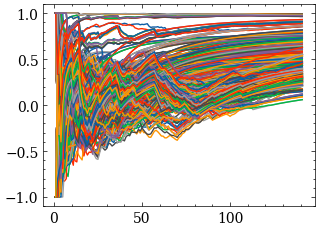

In [19]:
for key, val in KTtopK.items():
    plt.plot(val, label=key)
    
#plt.legend()

NameError: name 'cmap' is not defined

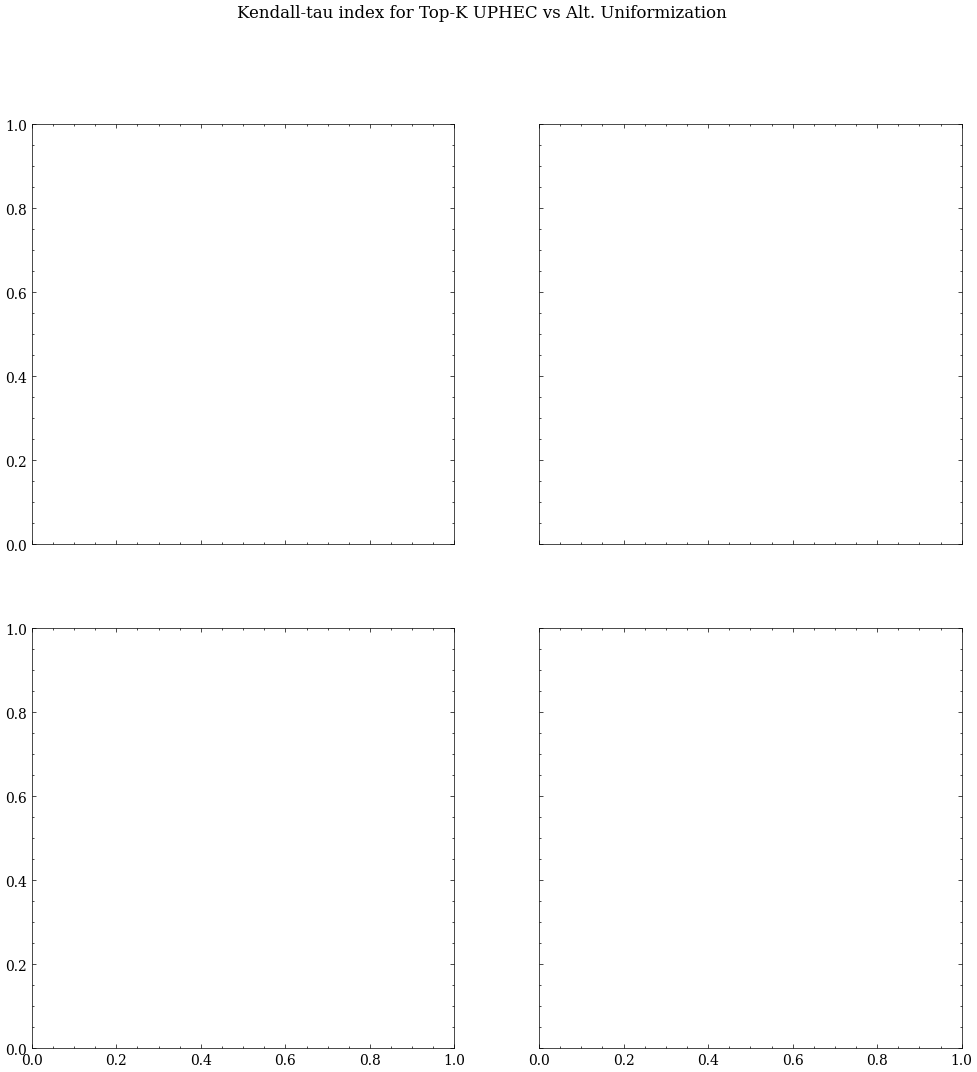

In [20]:
fig, ax = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)

fig.suptitle("Kendall-tau index for Top-K UPHEC vs Alt. Uniformization")

colorUU = iter(cmap(np.linspace(0, 1, 4*3)))
colorUA = iter(cmap(np.linspace(0, 1, 4*3)))
colorAU = iter(cmap(np.linspace(0, 1, 4*3)))
colorAA = iter(cmap(np.linspace(0, 1, 2*3)))

for key, val in KTtopK.items():
    
    if "UP" in key[0:3] and "UP" in key[-8:]:
        
        ax[0,0].plot(val, label=f"U{key[6]}" + r"$\rightarrow$"+ f"U{key[-1]}", color=next(colorUU))
        ax[0,0].set_title("UPHEC - UPHEC")
    
    elif "UP" in key[0:3] and "Alt" in key[-9:]:
        
        ax[0,1].plot(val, label=f"U{key[6]}" + r"$\rightarrow$"+ f"A{key[-1]}", color=next(colorUA))
        ax[0,1].set_title("UPHEC - Alt. Unif.")
    
    elif "Alt" in key[0:8] and "UP" in key[-8:]:
        
        ax[1,0].plot(val, label=f"A{key[8]}" + r"$\rightarrow$"+ f"U{key[-1]}", color=next(colorAU))
        ax[1,0].set_title("Alt. Unif. - UPHEC")
    
    elif "Alt" in key[0:8] and "Alt" in key[-9:]:
        
        ax[1,1].plot(val, label=f"A{key[8]}" + r"$\rightarrow$"+ f"A{key[-1]}", color=next(colorAA))
        ax[1,1].set_title("Alt. Unif. - Alt. Unif.")
        
        
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')


ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

plt.tight_layout()

plt.show()

In [ ]:
axisdict = {}
datadict = {}

for key, val in KTtopK.items():    
    
    if "UP" in key[0:3] and "UP" in key[-8:]:
        
        label=f"U{key[6]}" + r"$\rightarrow$"+ f"U{key[-1]}"
        axisdict[label] = (0,0)
        datadict[label] = val[10:]
    
    elif "UP" in key[0:3] and "unif" in key[-5:]:
        
        label=f"U{key[6]}" + r"$\rightarrow$"+ f"H{key[-5]}"
        axisdict[label] = (0,1)
        datadict[label] = val[10:]
        
    elif "unif" in key[0:9] and "UP" in key[-8:]:
        
        label=f"H{key[4]}" + r"$\rightarrow$"+ f"U{key[-1]}"
        axisdict[label] = (0,2)
        datadict[label] = val[10:]
        
    
    elif "Alt" in key[0:8] and "Alt" in key[-9:]:

        label=f"A{key[8]}" + r"$\rightarrow$"+ f"A{key[-1]}"
        axisdict[label] = (1,0)
        datadict[label] = val[10:]
        
    elif "UP" in key[0:3] and "Alt" in key[-9:]:
        
        label=f"U{key[6]}" + r"$\rightarrow$"+ f"A{key[-1]}"
        axisdict[label] = (1,1)
        datadict[label] = val[10:]
        
    elif "Alt" in key[0:8] and "UP" in key[-8:]:
        
        label=f"A{key[8]}" + r"$\rightarrow$"+ f"U{key[-1]}"
        axisdict[label] = (1,2)
        datadict[label] = val[10:]
        

In [ ]:
maxs = {}
mins = {}
means = {}

for label, data in datadict.items():
    maxs[label] = max(data)
    mins[label] = min(data)
    means[label] = np.mean(data)

In [ ]:
# Filter what to plot
labels_to_plot = set()
for axis in [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]:
    
    axlabels = [label for label in maxs.keys() if axisdict[label] == axis]
    
    maxax = [maxim for label, maxim in maxs.items() if axisdict[label] == axis]
    
    labels_to_plot.add(axlabels[maxax.index(max(maxax))])
    
    minax = [minim for label, minim in mins.items() if axisdict[label] == axis]
    
    labels_to_plot.add(axlabels[minax.index(min(minax))])
    
    meanax = [mean for label, mean in means.items() if axisdict[label] == axis]
    
    labels_to_plot.add(axlabels[meanax.index(max(meanax))])
    labels_to_plot.add(axlabels[meanax.index(min(meanax))])
    

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(11,6.5), sharex=True, sharey=True)

#fig.suptitle("Kendall-tau index for Top-K UPHEC vs Alt. Uniformization")

for label, data in datadict.items():
    
    if label in labels_to_plot:
        ax[axisdict[label][0],axisdict[label][1]].plot(range(11,len(df)), data,
                                                       label=label, linewidth=2)
    
        
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[0,2].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
ax[1,2].set_xscale('log')


ax[0,0].legend(loc="lower right")
ax[0,1].legend(loc="lower right")
ax[0,2].legend(loc="lower right")
ax[1,0].legend(loc="lower right")
ax[1,1].legend(loc="lower right")
ax[1,2].legend(loc="lower right")

plt.tight_layout()

#plt.savefig("Figures/diseasome_KT_topK_comparisons_simple.svg")

plt.show()